In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import root_mean_squared_error
import re

#hyperparameters
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30 

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# Data Cleaning Functions
def clean_volume(volume_str):
    if isinstance(volume_str, (int, float)):
        return volume_str
    if not isinstance(volume_str, str):
        return np.nan
    volume_str = volume_str.strip().upper()
    if volume_str == '-' or volume_str == '':
        return np.nan
    multipliers = {'K': 10**3, 'M': 10**6, 'B': 10**9}
    if volume_str[-1] in multipliers:
        return float(volume_str[:-1]) * multipliers[volume_str[-1]]
    try:
        return float(volume_str)
    except ValueError:
        return np.nan

def clean_change_pct(change_str):
    if isinstance(change_str, (int, float)):
        return change_str
    if not isinstance(change_str, str):
        return np.nan
    change_str = change_str.strip()
    if change_str == '-' or change_str == '':
        return np.nan
    if change_str.endswith('%'):
        try:
            return float(change_str[:-1]) / 100.0
        except ValueError:
            return np.nan
    try:
        return float(change_str)
    except ValueError:
        return np.nan

# Sequence creation function
def create_sequences_from_combined_array(all_scaled_data, seq_len, list_of_target_indices_in_data):
    Xs, ys = [], []
    all_scaled_data_np = np.array(all_scaled_data)
    if all_scaled_data_np.ndim == 1: # Handle case where only one feature/target is scaled
        all_scaled_data_np = all_scaled_data_np.reshape(-1,1)
    for i in range(len(all_scaled_data_np) - seq_len):
        Xs.append(all_scaled_data_np[i:(i + seq_len), :]) 
        ys.append(all_scaled_data_np[i + seq_len, list_of_target_indices_in_data])
    return np.array(Xs), np.array(ys)

In [2]:
# --- Centralized Data Loading & Preprocessing for DowJones.ipynb ---
df_dj = pd.read_csv("Dow Jones Industrial Average Historical Data 5Y.csv")

# Initial column cleanup and type conversion
df_dj['Date'] = pd.to_datetime(df_dj['Date'])
df_dj.rename(columns={
    'Close/Last': 'CloseLast', 
    'Vol.': 'Vol', 
    'Change %': 'ChangePct'
}, inplace=True)

df_dj.set_index('Date', inplace=True)
df_dj.sort_index(inplace=True)

# Apply cleaning functions
if 'Vol' in df_dj.columns:
    df_dj['Vol'] = df_dj['Vol'].apply(clean_volume)
if 'ChangePct' in df_dj.columns:
    df_dj['ChangePct'] = df_dj['ChangePct'].apply(clean_change_pct)
    df_dj['ChangePct_lagged'] = df_dj['ChangePct'].shift(1)

# Define features and target
# !!! IMPORTANT: Review and adjust 'features_for_scaling' and 'target_col_name' to your actual needs! !!!
target_col_name = 'CloseLast' # Assuming 'CloseLast' is the target to predict
features_to_include = ['Open', 'High', 'Low', 'CloseLast', 'Vol', 'ChangePct_lagged']

# Ensure only existing columns are used (e.g., if 'Vol' or 'ChangePct_lagged' wasn't in original or created)
features_present_in_df = [f for f in features_to_include if f in df_dj.columns]

# Columns for scaling: includes input features and the target variable itself
# This matches the pattern where target_indices are derived from a list of all scaled columns.
features_for_scaling = list(features_present_in_df) # Start with input features
if target_col_name not in features_for_scaling and target_col_name in df_dj.columns:
    features_for_scaling.append(target_col_name)
features_for_scaling = list(dict.fromkeys(features_for_scaling)) # Unique, preserve order

if target_col_name not in features_for_scaling:
    raise ValueError(f"Target column '{target_col_name}' must be in 'features_for_scaling'. Available: {df_dj.columns.tolist()}")

target_idx_in_scaled_data = [features_for_scaling.index(target_col_name)] # List with a single index

# Handle NaNs from lagging or cleaning, then select final columns for processing
df_processed = df_dj[features_for_scaling].copy()
df_processed.dropna(inplace=True)

data_to_scale = df_processed.values
dates_processed = df_processed.index # These are the dates corresponding to data_to_scale

# --- Data Splitting (by year) ---
# Years for different sets (adjust as needed)
train_start_year, train_end_year = 2019, 2023
test_year = 2024 # For initial evaluation after first training
final_val_year = 2025 # For hyperparameter tuning validation and final model evaluation

train_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= train_end_year)
test_idx_bool = dates_processed.year == test_year
val2025_idx_bool = dates_processed.year == final_val_year
trainval_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= test_year) # Train up to 2024 for 2025 validation

# --- Scaling (Fit ONLY on initial training data) ---
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(data_to_scale[train_idx_bool])

# Transform other datasets using the SAME fitted scaler
scaled_test_data = scaler.transform(data_to_scale[test_idx_bool])
scaled_val2025_data = scaler.transform(data_to_scale[val2025_idx_bool])
scaled_trainval_data = scaler.transform(data_to_scale[trainval_idx_bool])

# --- Sequence Creation for all datasets ---
X_train, y_train = create_sequences_from_combined_array(scaled_train_data, SEQ_LEN, target_idx_in_scaled_data)
X_test, y_test = create_sequences_from_combined_array(scaled_test_data, SEQ_LEN, target_idx_in_scaled_data)
X_val2025, y_val2025 = create_sequences_from_combined_array(scaled_val2025_data, SEQ_LEN, target_idx_in_scaled_data)
X_trainval, y_trainval = create_sequences_from_combined_array(scaled_trainval_data, SEQ_LEN, target_idx_in_scaled_data)

# --- Corresponding Dates for Sequences (for plotting) ---
# dates_processed corresponds to data_to_scale. Slicing for sequences needs the boolean mask AND SEQ_LEN offset.
dates_train_seq = dates_processed[train_idx_bool][SEQ_LEN:]
dates_test_seq = dates_processed[test_idx_bool][SEQ_LEN:]
dates_val2025_seq = dates_processed[val2025_idx_bool][SEQ_LEN:]
dates_trainval_seq = dates_processed[trainval_idx_bool][SEQ_LEN:]

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Shape of X_val2025: {X_val2025.shape}, y_val2025: {y_val2025.shape}")
print(f"Shape of X_trainval: {X_trainval.shape}, y_trainval: {y_trainval.shape}")
print(f"Number of features for scaling: {len(features_for_scaling)}")
print(f"Feature names for scaling: {features_for_scaling}")
print(f"Target index in scaled data: {target_idx_in_scaled_data}")

Shape of X_train: (887, 20, 6), y_train: (887, 1)
Shape of X_test: (232, 20, 6), y_test: (232, 1)
Shape of X_val2025: (75, 20, 6), y_val2025: (75, 1)
Shape of X_trainval: (1139, 20, 6), y_trainval: (1139, 1)
Number of features for scaling: 6
Feature names for scaling: ['Open', 'High', 'Low', 'CloseLast', 'Vol', 'ChangePct_lagged']
Target index in scaled data: [3]


In [3]:
# --- Model Definitions ---
class StockGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

--- Initial Training for GRU ---
Initial GRU: Epoch [10/30], Loss: 0.0009
Initial GRU: Epoch [20/30], Loss: 0.0007
Initial GRU: Epoch [30/30], Loss: 0.0005
Initial GRU - Test RMSE (2024): 542.52
--- Initial Training for LSTM ---
Initial LSTM: Epoch [10/30], Loss: 0.0012
Initial LSTM: Epoch [20/30], Loss: 0.0008
Initial LSTM: Epoch [30/30], Loss: 0.0013
Initial LSTM - Test RMSE (2024): 978.52
--- Initial Training for RNN ---
Initial RNN: Epoch [10/30], Loss: 0.0011
Initial RNN: Epoch [20/30], Loss: 0.0006
Initial RNN: Epoch [30/30], Loss: 0.0007
Initial RNN - Test RMSE (2024): 861.00


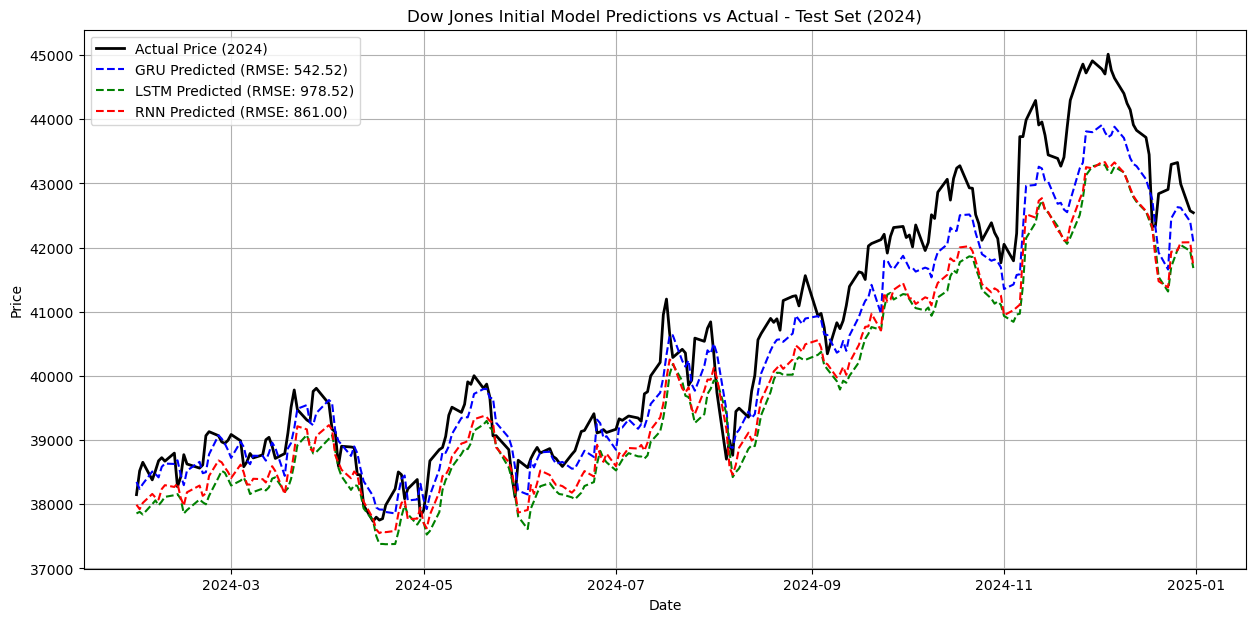

In [4]:
# --- Initial Training and Evaluation (Train: 2019-2023, Test: 2024) for all models ---

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset_init = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_init = DataLoader(train_dataset_init, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_init = TensorDataset(X_test_tensor, y_test_tensor)
test_loader_init = DataLoader(test_dataset_init, batch_size=BATCH_SIZE, shuffle=False)

input_size_init = X_train.shape[2]
initial_models = {}
initial_results = {}

model_classes = {"GRU": StockGRU, "LSTM": StockLSTM, "RNN": StockRNN}
plot_colors_init = {"GRU": "blue", "LSTM": "green", "RNN": "red"}

for model_name, ModelClass in model_classes.items():
    print(f"--- Initial Training for {model_name} ---")
    H_init, L_init, LR_init = 64, 2, 0.001 # Common initial hyperparameters
    
    model = ModelClass(input_size_init, H_init, L_init, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_init)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader_init:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Initial {model_name}: Epoch [{epoch+1}/{N_EPOCHS}], Loss: {loss.item():.4f}')
    initial_models[model_name] = model
    
    # Evaluate on 2024 test set
    model.eval()
    preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader_init:
            output = model(X_batch)
            preds_scaled.extend(output.numpy())
    preds_scaled = np.array(preds_scaled)
    
    # Inverse transform predictions and actuals
    # Create dummy array for inverse transform (shape: samples, num_features_scaled)
    dummy_preds = np.zeros((len(preds_scaled), len(features_for_scaling)))
    dummy_preds[:, target_idx_in_scaled_data[0]] = preds_scaled.flatten() # preds_scaled is (N,1), target_idx is list [idx]
    preds_inversed = scaler.inverse_transform(dummy_preds)[:, target_idx_in_scaled_data[0]]
    
    dummy_actuals = np.zeros((len(y_test), len(features_for_scaling)))
    dummy_actuals[:, target_idx_in_scaled_data[0]] = y_test.flatten() # y_test is (N,1)
    actuals_inversed = scaler.inverse_transform(dummy_actuals)[:, target_idx_in_scaled_data[0]]
    
    rmse = root_mean_squared_error(actuals_inversed, preds_inversed)
    print(f'Initial {model_name} - Test RMSE (2024): {rmse:.2f}')
    initial_results[model_name] = {'rmse': rmse, 'preds_inversed': preds_inversed, 'actuals_inversed': actuals_inversed}

# Plot initial test results (2024)
plt.figure(figsize=(15, 7))
plt.plot(dates_test_seq, initial_results["GRU"]['actuals_inversed'], label='Actual Price (2024)', color='black', linewidth=2)
for model_name in initial_models.keys():
    plt.plot(dates_test_seq, initial_results[model_name]['preds_inversed'], 
             label=f'{model_name} Predicted (RMSE: {initial_results[model_name]["rmse"]:.2f})', 
             color=plot_colors_init[model_name], linestyle='--')
plt.title(f'Dow Jones Initial Model Predictions vs Actual - Test Set (2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparameter Tuning & Final Validation (Train: 2019-2024, Validate: 2025)

In [5]:
# --- Data Preparation for Hyperparameter Tuning ---
# Training on 2019-2024 (X_trainval, y_trainval), Validating on 2025 (X_val2025, y_val2025)
# These datasets (X_trainval, etc.) were already created and scaled correctly in Cell 2.

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32)
X_final_val_tensor = torch.tensor(X_val2025, dtype=torch.float32) # Using X_val2025 for final validation
y_final_val_tensor = torch.tensor(y_val2025, dtype=torch.float32) # Using y_val2025 for final validation

trainval_dataset = TensorDataset(X_trainval_tensor, y_trainval_tensor)
trainval_loader = DataLoader(trainval_dataset, batch_size=BATCH_SIZE, shuffle=True)

final_val_dataset = TensorDataset(X_final_val_tensor, y_final_val_tensor)
final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Shape of X_trainval_tensor: {X_trainval_tensor.shape}")
print(f"Shape of X_final_val_tensor: {X_final_val_tensor.shape}")

Shape of X_trainval_tensor: torch.Size([1139, 20, 6])
Shape of X_final_val_tensor: torch.Size([75, 20, 6])


In [6]:
# --- Hyperparameter Tuning Loop for each model type ---
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}
all_params_tuning = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

results_tuning = {}
best_configs_tuning = {}
best_model_states_tuning = {}

input_size_tuning = X_trainval.shape[2]

for model_name, ModelClass in model_classes.items():
    print(f"\n--- Hyperparameter Tuning for {model_name} ---")
    best_val_rmse_model = float('inf')
    best_params_model = None
    best_model_state_model = None
    model_tuning_log = []

    for params in all_params_tuning:
        H, L, LR = params['hidden_size'], params['num_layers'], params['learning_rate']
        # print(f"Tuning {model_name} with H={H}, L={L}, LR={LR}") # Can be verbose
        
        current_model_tuning = ModelClass(input_size_tuning, H, L, output_size=1)
        criterion_tuning = nn.MSELoss()
        optimizer_tuning = torch.optim.Adam(current_model_tuning.parameters(), lr=LR)
        
        # Reduced epochs for faster tuning, adjust if needed
        for epoch in range(N_EPOCHS // 2): 
            current_model_tuning.train()
            for X_batch, y_batch in trainval_loader:
                optimizer_tuning.zero_grad()
                output = current_model_tuning(X_batch)
                loss = criterion_tuning(output, y_batch)
                loss.backward()
                optimizer_tuning.step()
        
        current_model_tuning.eval()
        current_val_preds_scaled = []
        with torch.no_grad():
            for X_batch, y_batch in final_val_loader:
                output = current_model_tuning(X_batch)
                current_val_preds_scaled.extend(output.numpy())
        current_val_preds_scaled = np.array(current_val_preds_scaled)
        
        dummy_preds_val = np.zeros((len(current_val_preds_scaled), len(features_for_scaling)))
        dummy_preds_val[:, target_idx_in_scaled_data[0]] = current_val_preds_scaled.flatten()
        current_val_preds_inversed = scaler.inverse_transform(dummy_preds_val)[:, target_idx_in_scaled_data[0]]
        
        # y_val2025 is the original scaled target for the 2025 validation set
        dummy_actuals_val = np.zeros((len(y_val2025), len(features_for_scaling)))
        dummy_actuals_val[:, target_idx_in_scaled_data[0]] = y_val2025.flatten()
        y_val2025_inversed = scaler.inverse_transform(dummy_actuals_val)[:, target_idx_in_scaled_data[0]]
        
        current_rmse_val = root_mean_squared_error(y_val2025_inversed, current_val_preds_inversed)
        model_tuning_log.append({'params': params, 'val_rmse': current_rmse_val})
        # print(f"{model_name} H={H},L={L},LR={LR} -> Val RMSE (2025): {current_rmse_val:.2f}")
        
        if current_rmse_val < best_val_rmse_model:
            best_val_rmse_model = current_rmse_val
            best_params_model = params
            best_model_state_model = current_model_tuning.state_dict()
    results_tuning[model_name] = {
        'best_val_rmse_2025': best_val_rmse_model,
        'best_params': best_params_model,
        'log': model_tuning_log,
        'actual_2025': y_val2025_inversed, # Store for final plot
        # Predictions for best model will be re-calculated below for clarity
    }
    best_configs_tuning[model_name] = best_params_model
    best_model_states_tuning[model_name] = best_model_state_model
    print(f"Best Validation RMSE for {model_name} (2025): {best_val_rmse_model:.2f} with params: {best_params_model}")


--- Hyperparameter Tuning for GRU ---
Best Validation RMSE for GRU (2025): 683.94 with params: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.001}

--- Hyperparameter Tuning for LSTM ---
Best Validation RMSE for LSTM (2025): 828.55 with params: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.001}

--- Hyperparameter Tuning for RNN ---
Best Validation RMSE for RNN (2025): 685.09 with params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}


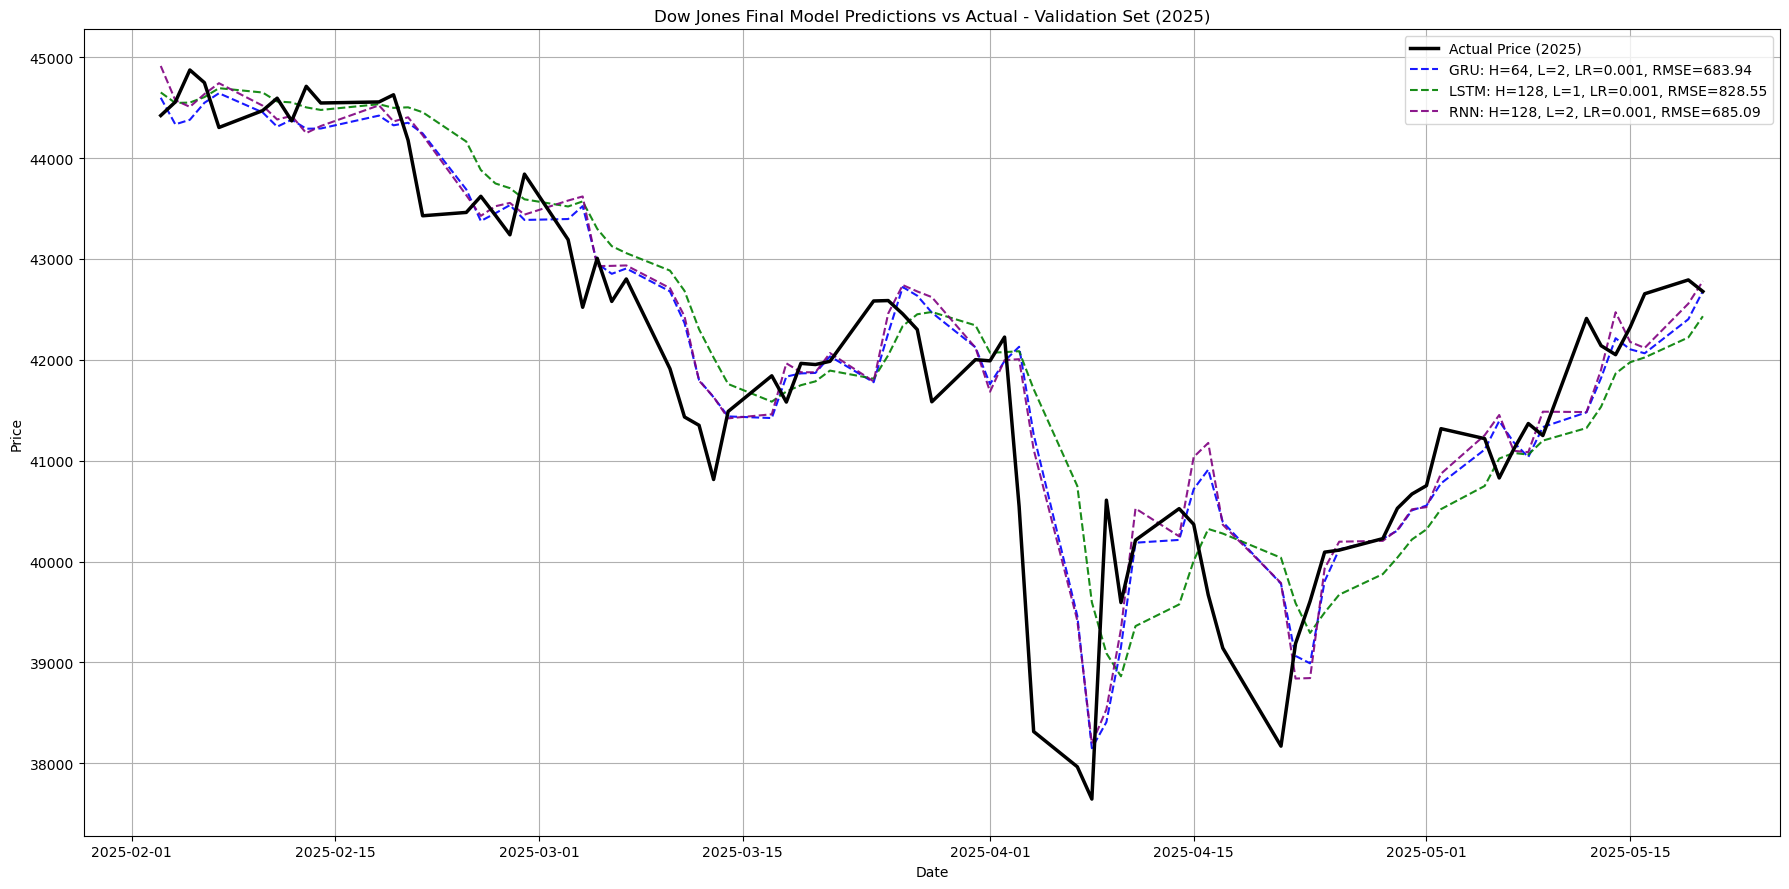

In [7]:
# --- Final Evaluation and Plotting with Best Tuned Models on 2025 Validation Set ---
plt.figure(figsize=(18, 9))

# Plot actual 2025 data once
actual_2025_data_for_plot = results_tuning.get("GRU", {}).get("actual_2025") # Get from any model, should be same
if actual_2025_data_for_plot is not None:
    plt.plot(dates_val2025_seq, actual_2025_data_for_plot, label='Actual Price (2025)', color='black', linewidth=2.5, zorder=5)

final_plot_colors = {"GRU": "blue", "LSTM": "green", "RNN": "purple"}

for model_name, ModelClass in model_classes.items():
    if model_name not in best_configs_tuning or best_configs_tuning[model_name] is None:
        print(f"No best configuration found for {model_name}. Skipping final plot.")
        continue
        
    best_params = best_configs_tuning[model_name]
    best_model_final = ModelClass(input_size_tuning, 
                                  best_params['hidden_size'], 
                                  best_params['num_layers'], 
                                  output_size=1)
    best_model_final.load_state_dict(best_model_states_tuning[model_name])
    best_model_final.eval()
    
    final_preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader:
            output = best_model_final(X_batch)
            final_preds_scaled.extend(output.numpy())
    final_preds_scaled = np.array(final_preds_scaled)
    
    dummy_final_preds = np.zeros((len(final_preds_scaled), len(features_for_scaling)))
    dummy_final_preds[:, target_idx_in_scaled_data[0]] = final_preds_scaled.flatten()
    final_preds_inversed = scaler.inverse_transform(dummy_final_preds)[:, target_idx_in_scaled_data[0]]
    
    # Store these predictions for the `results` dictionary if needed by original final plot cell structure
    results_tuning[model_name]['pred_2025_final_best'] = final_preds_inversed
    final_rmse = results_tuning[model_name]['best_val_rmse_2025'] # This was already calculated with these predictions
    
    legend_label = f"{model_name}: H={best_params['hidden_size']}, L={best_params['num_layers']}, LR={best_params['learning_rate']}, RMSE={final_rmse:.2f}"
    plt.plot(dates_val2025_seq, final_preds_inversed, 
             label=legend_label, 
             color=final_plot_colors[model_name], 
             linestyle='--', alpha=0.9)

plt.title(f'Dow Jones Final Model Predictions vs Actual - Validation Set (2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()